# Parte 2 - Classificação de Algarismos

Nesta parte, comparamos o desempenho de diferentes algoritmos de classificação supervisionada na tarefa de identificar algarismos a partir de imagens 8x8. Para isso usamos as imagens disponíveis no Pen-Based
Recognition of Handwritten Digits Data Set e acessíveis pelo sklearn através da função load_digits. Os dados estão disponíveis em forma de imagem em digits.image ou em forma de vetor em digits.data e a classe de cada dado pode ser encontrada em digits.target.

Abaixo, demonstramos os 10 primeiros algarismos do conjunto de dados em forma de imagem:

0


<Figure size 432x288 with 0 Axes>

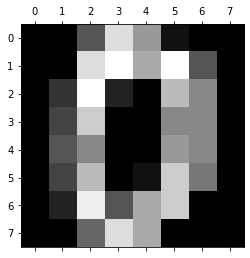

1


<Figure size 432x288 with 0 Axes>

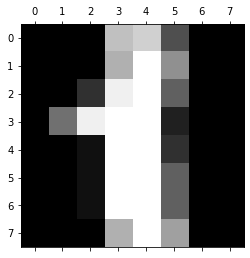

2


<Figure size 432x288 with 0 Axes>

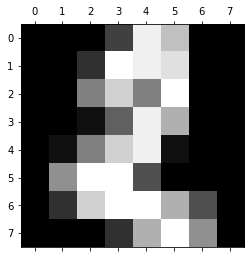

3


<Figure size 432x288 with 0 Axes>

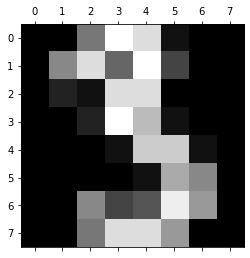

4


<Figure size 432x288 with 0 Axes>

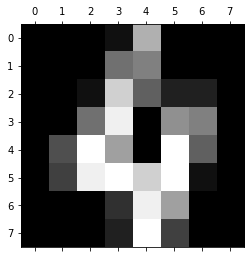

5


<Figure size 432x288 with 0 Axes>

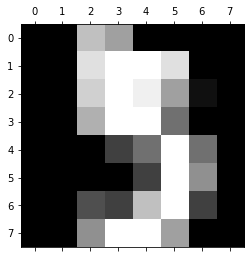

6


<Figure size 432x288 with 0 Axes>

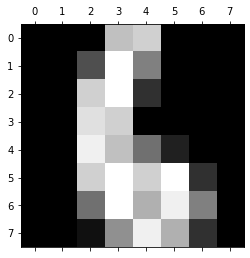

7


<Figure size 432x288 with 0 Axes>

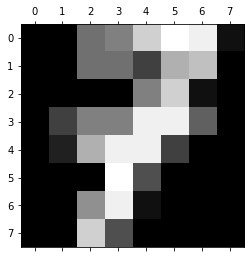

8


<Figure size 432x288 with 0 Axes>

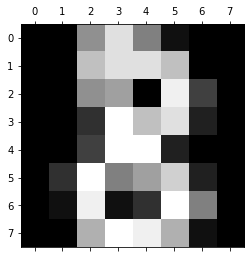

9


<Figure size 432x288 with 0 Axes>

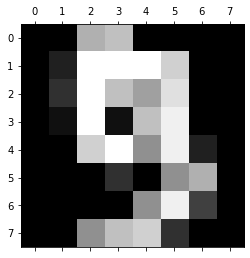

In [1]:
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt

digits = load_digits()
for i in range(10):
    print(digits.target[i])
    plt.gray() 
    plt.matshow(digits.images[i]) 
    plt.show() 

Em seguida, separamos os dados em conjuntos de treinamento (90%) e de teste (10%):

In [2]:
from sklearn.model_selection import train_test_split

digits_data_train_and_val, digits_data_test, digits_target_train_and_val, digits_target_test = \
        train_test_split(digits.data, digits.target, test_size=0.1, random_state=42)

print("Dados para treino:", digits_data_train_and_val.shape[0])
print("Dados para teste:", digits_data_test.shape[0])

Dados para treino: 1617
Dados para teste: 180


Como cada dado possui 64 *features*, fizemos a **estandardização** dos dados e usamos o algoritmo **LDA** para diminuir sua dimensão de forma a aumentar sua densidade. Dessa forma, facilitando o treinamento de algoritmos de classificação.

In [3]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = make_pipeline(StandardScaler(), LinearDiscriminantAnalysis())
reduced_digits_data_train_and_val = lda.fit_transform(digits_data_train_and_val, digits_target_train_and_val)
reduced_digits_data_test = lda.transform(digits_data_test)
print("A dimensionalidade dos dados foi reduzida de %d para %d." \
      % (digits.data.shape[1], reduced_digits_data_train_and_val.shape[1]))

A dimensionalidade dos dados foi reduzida de 64 para 9.


Para visualizar os dados, utilizamos o algoritmo **t-SNE**. Ele foi criado com o propósito de reduzir a dimensionalidade de um conjunto de dados para sua visualização.

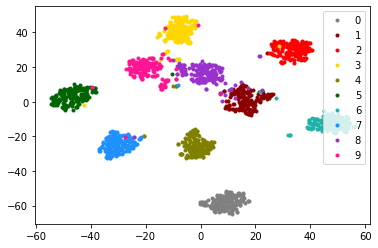

In [4]:
from sklearn.manifold import TSNE
import numpy as np

viz_digits_data_train_and_val = TSNE(n_components=2, random_state=42).fit_transform(reduced_digits_data_train_and_val)

colors = ['gray', 'darkred', 'red', 'gold', 'olive', 'darkgreen', 'lightseagreen', 'dodgerblue', 'darkorchid', 'deeppink']
for i in range(10):
    indices = np.where(digits_target_train_and_val == i)
    selected_data = np.take(viz_digits_data_train_and_val, indices, 0)
    plt.plot(selected_data[0,:,0], selected_data[0,:,1], '.', color=colors[i], label=i)
plt.legend()
plt.show()

Em seguida, separamos os dados entre treino e validação e usamos dois métodos de classificação: **KNN** e **árvores de decisões**. Para cada método, variamos alguns de seus parâmetros de entrada para podermos em seguida comparar a eficácia do treino e escolher o modelo que melhor representa os dados.

In [5]:
digits_data_train, digits_data_val, digits_target_train, digits_target_val = \
        train_test_split(reduced_digits_data_train_and_val, digits_target_train_and_val, test_size=0.1, \
                         random_state=42)

print("Dados para treino:", digits_data_train.shape[0])
print("Dados para validação:", digits_data_val.shape[0])

Dados para treino: 1455
Dados para validação: 162


Para as **árvores de decisões**, variamos a profundidade máxima da árvore. Quanto menor a profundidade, menos especializado o modelo é para o conjunto de dados fornecidos. Também adicionamos uma árvore treinada sem altura máxima, que será treinada até que o modelo seja capaz de classificar todos os dados do conjunto de treino com precisão absoluta.

In [6]:
from sklearn.tree import DecisionTreeClassifier

decision_tree_classifiers = []

clf = DecisionTreeClassifier(random_state=42)
clf.fit(digits_data_train, digits_target_train)
print("Profundidade da árvore sem limite:", clf.get_depth())
decision_tree_classifiers.append(clf)

for i in range(1, 16):
    clf = DecisionTreeClassifier(random_state=42, max_depth=i)
    clf.fit(digits_data_train, digits_target_train)
    decision_tree_classifiers.append(clf)

Profundidade da árvore sem limite: 16


Para o algoritmo **KNN**, variamos o número de vizinhos usados para a classificação e a forma como as distâncias entre os pontos são ponderadas. O modo *uniform* utiliza o mesmo peso para todos os pontos. Já o modo *distance* aumenta o peso de vizinhos mais próximos.

In [7]:
from sklearn.neighbors import KNeighborsClassifier

knn_classifiers_uniform_weight = []
for i in range(1, 16):
    clf = KNeighborsClassifier(n_neighbors=i, weights='uniform')
    clf.fit(digits_data_train, digits_target_train)
    knn_classifiers_uniform_weight.append(clf)

knn_classifiers_distance_weight = []
for i in range(1, 16):
    clf = KNeighborsClassifier(n_neighbors=i, weights='distance')
    clf.fit(digits_data_train, digits_target_train)
    knn_classifiers_distance_weight.append(clf)

Agora avaliamos, dentre os modelos treinados acima, quais apresentam melhor desempenho no conjunto de dados separados para validação. Para fazer essa medição, utilizamos o **F1 Score**, que consiste em uma média harmônica da precisão e do recall.

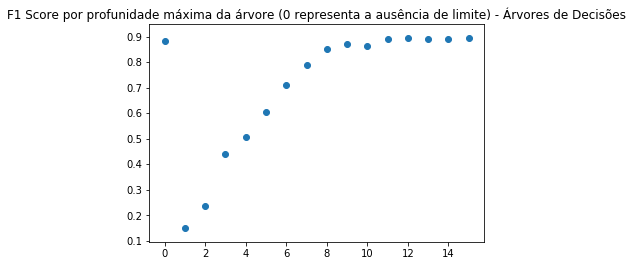

Score mínimo: 0.14814814814814814 profundidade: 1
Score máximo: 0.8950617283950617 profundidade: 12


In [8]:
from sklearn.metrics import f1_score

score_decision_tree = []
for clf in decision_tree_classifiers:
    prediction = clf.predict(digits_data_val)
    score_decision_tree.append(f1_score(digits_target_val, prediction, average='micro'))

plt.title("F1 Score por profunidade máxima da árvore (0 representa a ausência de limite) - Árvores de Decisões")
plt.scatter(list(range(16)), score_decision_tree)
plt.show()

min_value = min(score_decision_tree)
min_index = score_decision_tree.index(min_value)

max_value = max(score_decision_tree)
max_index = score_decision_tree.index(max_value)

best_decision_tree = decision_tree_classifiers[max_index]
best_decision_tree_score_val = max_value

print("Score mínimo:", min_value, "profundidade:", min_index)
print("Score máximo:", max_value, "profundidade:", max_index)

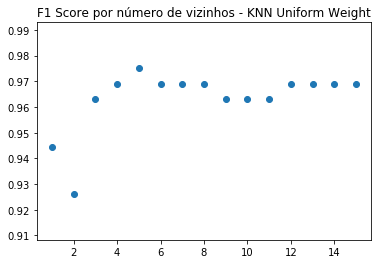

Score mínimo: 0.9259259259259259 vizinhos: 2
Score máximo: 0.9753086419753086 vizinhos: 5


In [9]:
score_knn_uniform_weight = []

for clf in knn_classifiers_uniform_weight:
    prediction = clf.predict(digits_data_val)
    score_knn_uniform_weight.append(f1_score(digits_target_val, prediction, average='micro'))
    
plt.title("F1 Score por número de vizinhos - KNN Uniform Weight")
plt.scatter(list(range(1, 16)), score_knn_uniform_weight)
plt.show()

min_value = min(score_knn_uniform_weight)
min_index = score_knn_uniform_weight.index(min_value)

max_value = max(score_knn_uniform_weight)
max_index = score_knn_uniform_weight.index(max_value)

best_knn_uniform_weight = knn_classifiers_uniform_weight[max_index]
best_knn_uniform_weight_score_val = max_value

print("Score mínimo:", min_value, "vizinhos:", min_index + 1)
print("Score máximo:", max_value, "vizinhos:", max_index + 1)

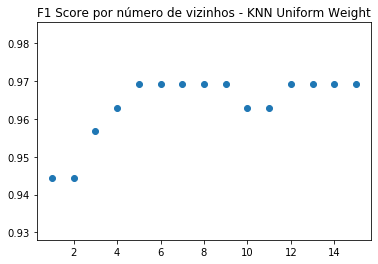

Score mínimo: 0.9444444444444444 vizinhos: 1
Score máximo: 0.9691358024691359 vizinhos: 5


In [10]:
score_knn_distance_weight = []

for clf in knn_classifiers_distance_weight:
    prediction = clf.predict(digits_data_val)
    score_knn_distance_weight.append(f1_score(digits_target_val, prediction, average='micro'))
    
plt.title("F1 Score por número de vizinhos - KNN Uniform Weight")
plt.scatter(list(range(1, 16)), score_knn_distance_weight)
plt.show()

min_value = min(score_knn_distance_weight)
min_index = score_knn_distance_weight.index(min_value)

max_value = max(score_knn_distance_weight)
max_index = score_knn_distance_weight.index(max_value)

best_knn_distance_weight = knn_classifiers_distance_weight[max_index]
best_knn_distance_weight_score_val = max_value

print("Score mínimo:", min_value, "vizinhos:", min_index + 1)
print("Score máximo:", max_value, "vizinhos:", max_index + 1)

Agora que selecionamos três modelos treinados para classificar as imagens, vamos avaliar sua eficácia no conjunto de testes. Para isso, usamos novamente o **F1 score** para permitir a comparação com a eficácia no conjunto de validação. Além disso, plotamos a **matriz de confusão**, que permite uma análise mais detalhada por separar a eficácia para cada algarismo.

F1 Score da árvore de decisão no conjunto de validação: 0.8950617283950617
F1 Score da árvore de decisão no conjunto de testes: 0.9166666666666666


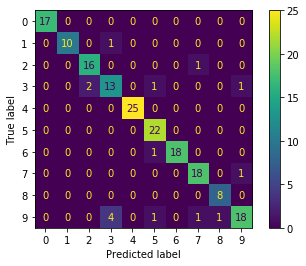

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

prediction_decision_tree = best_decision_tree.predict(reduced_digits_data_test)
best_decision_tree_score_test = f1_score(digits_target_test, prediction_decision_tree, average='micro')

print("F1 Score da árvore de decisão no conjunto de validação:", best_decision_tree_score_val)
print("F1 Score da árvore de decisão no conjunto de testes:", best_decision_tree_score_test)

cm = confusion_matrix(digits_target_test, prediction_decision_tree)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

F1 Score do KNN com peso uniforme no conjunto de validação: 0.9753086419753086
F1 Score do KNN com peso uniforme no conjunto de testes: 0.9722222222222222


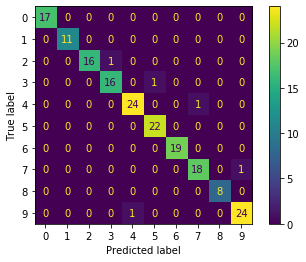

In [12]:
prediction_knn_uniform_weight = best_knn_uniform_weight.predict(reduced_digits_data_test)
best_knn_uniform_weight_score_test = f1_score(digits_target_test, prediction_knn_uniform_weight, average='micro')

print("F1 Score do KNN com peso uniforme no conjunto de validação:", best_knn_uniform_weight_score_val)
print("F1 Score do KNN com peso uniforme no conjunto de testes:", best_knn_uniform_weight_score_test)

cm = confusion_matrix(digits_target_test, prediction_knn_uniform_weight)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

F1 Score do KNN ponderado pela distância no conjunto de validação: 0.9691358024691359
F1 Score do KNN ponderado pela distância no conjunto de testes: 0.9722222222222222


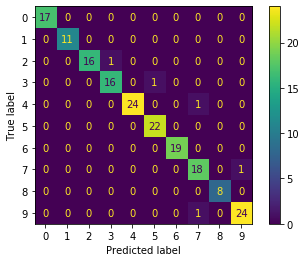

In [13]:
prediction_knn_distance_weight = best_knn_distance_weight.predict(reduced_digits_data_test)
best_knn_distance_weight_score_test = f1_score(digits_target_test, prediction_knn_distance_weight, average='micro')

print("F1 Score do KNN ponderado pela distância no conjunto de validação:", best_knn_distance_weight_score_val)
print("F1 Score do KNN ponderado pela distância no conjunto de testes:", best_knn_distance_weight_score_test)

cm = confusion_matrix(digits_target_test, prediction_knn_distance_weight)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

Como podemos observar, o algoritmo **KNN** foi mais eficiente em classificar os números que a **árvore de decisões**. Dentro do **KNN**, a separação entre a estratégia não-ponderada e a ponderada pelas distâncias resultou não ser muito relevante. Analisando a matriz de confusão de ambas estratégias, podemos detectar apenas uma diferença na linha 9 e, em ambos os casos, o algarismo foi identificado incorretamente.

Como o método **KNN** utiliza a distância para determinar a qual classe um dado pertence, podemos assumir que a utilização do algoritmo **LDA** (que tenta aumentar a distância entre dados de classes diferentes e diminuir a distância entre dados de uma mesma classe) no pré-processamento contribuiu para uma maior eficácia deste método.